## Introduction

Football analytics is a growing industry within the sport that every top team can’t neglect to utilize. While football has be slow to catch up with American sports in harnessing data as a valuable resource, the analytics industry now spans academia, data providers, gambling companies, and more. Part of the reason football has lagged behind baseball and basketball in this field was due to its low-scoring nature, and long stretches of un-interrupted play. In addition, because goal-scoring is the only determining factor for winning matches, the earliest statistical metrics were biased and could not fairly assess every player in the team.

Recently, machine learning algorithms have been published to help quantify the average positive (or negative) impact all actions taken by team members in a game. For my project, I will use the newly developed tool VAEP (Valuing Actions by Estimating probabilities) to compute every player impact in the recent Euro 2020 tournament. In addition, I will also the fairly recent xT (expected threat), and the older xG (expected goals) frameworks. In my analysis, I provide correlations between these statistics and the player’s market value on the popular transfermarkt website. I conclude with using these results to find undervalued players with high performance in this competition.

In [2]:
import re
from re import match
import pandas as pd
import numpy as np
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
import socceraction.vaep.features as fs
import socceraction.vaep.labels as lab
import socceraction.vaep.formula as vaepformula
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotsoccer as mps
import matplotlib.pyplot as plt
import seaborn as sns
import jellyfish
from tqdm import tqdm
import xgboost
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
import warnings
from bs4 import BeautifulSoup
from dateutil.parser import parse
import requests


warnings.filterwarnings('ignore')

In [3]:
#get indices for euro 2020 competition data
COMPETITION_IDX = 55
SEASON_IDX = 43

#define StatsBombLoader
SBL = StatsBombLoader()
df_competitions = SBL.competitions()

# 1. Initial Data Processing

In [4]:
#function getting game indices - there are 51 games
def get_games_idx(competition_id, season_id):
    df_games = SBL.games(competition_id=55, season_id=43)
    games_idx = list(df_games["game_id"])
    games_dict = {row["game_id"]: {"home_team_id": row["home_team_id"], "away_team_id": row["away_team_id"]} for idx, row in df_games.iterrows()}
    return games_idx, games_dict

#extract all players that participated in a single game
def get_all_players_single_game(game_id):
    df_players = SBL.players(game_id)
    df_players = df_players[
        [
            "player_id",
            "player_name",
            "team_id",
            "minutes_played"
        ]
    ]
    return df_players

#extract all players that participated in a competition. Filter out players that have played less than 45 minutes in total. 
def get_all_players(competition_id, season_id):
    games_idx, _ = get_games_idx(competition_id, season_id)
    players_df_list = []
    pbar = tqdm(games_idx)
    for game_idx in pbar:
        pbar.set_description(f"Extracting Players Data for Game ID: {game_idx}")
        df_players = get_all_players_single_game(game_id=game_idx)
        players_df_list.append(df_players)
    cumulative_players_df = pd.concat(players_df_list).reset_index(drop=True)
    min_played = dict(cumulative_players_df.groupby("player_name")["minutes_played"].sum())
    cumulative_players_df["minutes_played"] = cumulative_players_df["player_name"].apply(lambda x: min_played[x])
    cumulative_players_df = cumulative_players_df[cumulative_players_df["minutes_played"]>=45]
    cumulative_players_df.drop_duplicates(inplace=True)
    return cumulative_players_df

#create a dictionary with game events (passes, shots, etc). key - game ID, value - dataframe with events
def get_game_events(game_id):
    df_events_raw = SBL.events(game_id)
    df_events_game = dict(tuple(df_events_raw.groupby("team_id")))
    return df_events_game

#convert extracted competetions to socceraction SPADL format. key - game ID, value - dataframe with events
def get_games_actions_spadl_format(games_dict):
    games_actions_dict = {}
    pbar = tqdm(games_dict.items())
    for game_idx, team_dict in pbar:
        df_events = SBL.events(game_idx)
        pbar.set_description(f"Extracting Actions Data for Game ID: {game_idx}")
        
        df_events = SBL.events(game_idx)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, team_dict["home_team_id"])
        df_actions_ltr = spadl.play_left_to_right(df_actions, team_dict["home_team_id"])
        
        games_actions_dict[game_idx] = df_actions_ltr
        
    return games_actions_dict

In [5]:
#Use the above functions in order to get the data in a correct format
#Extract game indices and make a dictionary with key: game_id having inside "home_team_id" and "away_team_id"
games_idx, games_dict = get_games_idx(competition_id=COMPETITION_IDX, season_id=SEASON_IDX)

#get the dataframe with all players participating in Euro 2020
players_df = get_all_players(competition_id=COMPETITION_IDX, season_id=SEASON_IDX)

#get data about all actions for each game in Euro 2020
games_actions_dict = get_games_actions_spadl_format(games_dict=games_dict)

Extracting Actions Data for Game ID: 3788744: 100%|████████████████████████████████████| 51/51 [00:35<00:00,  1.42it/s]


# 2. Expected Threat (xT) Calculation

In [7]:
#build xT model
def build_xt_model(df_actions, l=16, w=12):
    xTModel = xthreat.ExpectedThreat(l=l, w=w)
    xTModel.fit(df_actions)
    return xTModel

#predict xT on a trained model 
def predict_xt_model(df_actions, xt_model):
    mov_actions = xthreat.get_successful_move_actions(df_actions)
    mov_actions["xT_value"] = xt_model.predict(mov_actions)
    xt_df = mov_actions[
        [
            "player_id",
            "start_x", 
            "start_y", 
            "end_x", 
            "end_y",
            "xT_value"
        ]
    ]
    return xt_df

#calculate xT for each player that participated in euro. Average over all games
def build_cumulative_players_xt(players_df, games_actions_dict, l=16, w=12):
    player_xt_list = []
    
    df_actions_cumulative = pd.concat([df_actions for _, df_actions in games_actions_dict.items()])
    xTModel = build_xt_model(df_actions_cumulative, l=l, w=w)
    xt_df = predict_xt_model(df_actions_cumulative, xTModel)
    players_xt_df = pd.DataFrame(xt_df.groupby("player_id")["xT_value"].sum())
    players_xt_df = players_xt_df.reset_index(drop=False)
    players_xt_df = pd.DataFrame(players_xt_df.groupby("player_id")["xT_value"].sum()).reset_index(drop=False)
    players_xt_df = pd.merge(
        left=players_xt_df,
        right=players_df,
        on=["player_id", "player_id"]
    )
    players_xt_df.sort_values("xT_value", inplace=True, ascending=False)
    
    return players_xt_df

In [8]:
#Use the above functions in order to calculate xT for each player
players_xt_df = build_cumulative_players_xt(
    players_df=players_df,
    games_actions_dict=games_actions_dict, 
    l=16, 
    w=12
)

# iterations:  55


# 3. Valuing Actions by Estimating Probabilities (VAEP) Calculation

In [10]:
#similar like in socceration notebooks. Create features and labels for fuether calculation
def compute_features_and_labels(games_dict, games_actions_dict):
    xfns = [
        fs.actiontype,
        fs.actiontype_onehot,
        fs.bodypart,
        fs.bodypart_onehot,
        fs.result,
        fs.result_onehot,
        fs.goalscore,
        fs.startlocation,
        fs.endlocation,
        fs.movement,
        fs.space_delta,
        fs.startpolar,
        fs.endpolar,
        fs.team,
        fs.time,
        fs.time_delta
    ]
    yfns = [
        lab.scores, 
        lab.concedes, 
        lab.goal_from_shot
    ]
    
    features_labels_dict = {}
    
    pbar = tqdm(games_dict.items())
    for game_idx, games_data in pbar:
        pbar.set_description(f"Calculating Features and Labels for Game ID: {game_idx}")
        features_labels_dict[game_idx] = {}
        gamestates = fs.gamestates(spadl.add_names(games_actions_dict[game_idx]), 3)
        gamestates = fs.play_left_to_right(gamestates, games_data["home_team_id"])
        X = pd.concat([fn(gamestates) for fn in xfns], axis=1)        
        Y = pd.concat([fn(spadl.add_names(games_actions_dict[game_idx])) for fn in yfns], axis=1)
        features_labels_dict[game_idx]["features"] = X
        features_labels_dict[game_idx]["labels"] = Y
    return features_labels_dict

#Create X and Y data (features and labels) for further model training 
def prepare_dataset_for_scoring_conceding_model(games_dict, features_labels_dict):
    xfns = [
        fs.actiontype,
        fs.actiontype_onehot,
        fs.bodypart_onehot,
        fs.result,
        fs.result_onehot,
        fs.goalscore,
        fs.startlocation,
        fs.endlocation,
        fs.movement,
        fs.space_delta,
        fs.startpolar,
        fs.endpolar,
        fs.team,
        fs.time_delta,
    ]
    nb_prev_actions = 1
    
    Xcols = fs.feature_column_names(xfns, nb_prev_actions)
    Ycols = ["scores", "concedes"]
    X = []
    Y = []
    
    pbar = tqdm(games_dict.items())
    for game_idx, _ in pbar:
        pbar.set_description(f"Processing Scoring and Conceding Features and Labels for Game ID: {game_idx}")
        X.append(features_labels_dict[game_idx]["features"][Xcols])
        Y.append(features_labels_dict[game_idx]["labels"][Ycols])
        
    X = pd.concat(X).reset_index(drop=True)
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

#train XGBoost model for estimating probabilities of Scoring and Conceding goals
def train_model_scoring_conceding(features, labels):
    for col in list(labels.columns):
        X_train, X_test, y_train, y_test = train_test_split(features, labels[col], test_size=0.2, random_state=42)
        model = xgboost.XGBClassifier(n_estimators=50, max_depth=3, n_jobs=-3, verbosity=1)
        model.fit(X_train, y_train)
        
        pred_test = model.predict(X_test)
        br_score = brier_score_loss(y_test, pred_test)
        roc_score = roc_auc_score(y_test, pred_test)
        print(f"\n\n- Brier score for {col} (testing subset): {br_score}")
        print(f"- ROC-AUC score for {col} (testing subset): {roc_score}")
    
    
    models = {}
    for col in list(labels.columns):
        model = xgboost.XGBClassifier(n_estimators=50, max_depth=3, n_jobs=-3, verbosity=1)
        model.fit(features, labels[col])
        models[col] = model
    return models

#predict Scoring and Conceding probabilities based on pre-calculated features
def predict_scoring_conceding_probas(models, features, labels, games_actions_dict):
    pred_dict = {}
    for col in list(labels.columns):
        pred_dict[col] = [p[1] for p in models[col].predict_proba(features)]
    
    pred_df = pd.concat([df for game_idx, df in games_actions_dict.items()])[["game_id"]].reset_index(drop=True)
    for col, pred in pred_dict.items():
        pred_df[col] = pred
    
    grouped_pred = dict(tuple(pred_df.groupby("game_id")))
    return grouped_pred

#calculate VAEP values based on trained model
def calculate_vaep_values(games_actions_dict, grouped_pred):
    actions_cumulative = spadl.add_names(pd.concat([df for game_idx, df in games_actions_dict.items()]))
    grouped_actions_cumulative = dict(tuple(actions_cumulative.groupby("game_id")))
    
    vaep_list = []
    for game_id, action_df in grouped_actions_cumulative.items():
        vaep_values = vaepformula.value(action_df, grouped_pred[game_id]["scores"], grouped_pred[game_id]["concedes"])
        vaep_list.append(pd.concat([action_df[["player_id"]], vaep_values], axis=1))
        
    vaep_df = pd.concat(vaep_list).dropna().reset_index(drop=True)
    vaep_df = pd.DataFrame(vaep_df.groupby("player_id").sum()).reset_index(drop=False)
    return vaep_df

In [11]:
#Use the above functions in order to calculate VAEP for each player
vaep_features_labels_dict = compute_features_and_labels(games_dict, games_actions_dict)
X_vaep, Y_vaep = prepare_dataset_for_scoring_conceding_model(games_dict, vaep_features_labels_dict)
scoring_conceding_models = train_model_scoring_conceding(features=X_vaep, labels=Y_vaep)
scoring_conceding_probas = predict_scoring_conceding_probas(scoring_conceding_models, X_vaep, Y_vaep, games_actions_dict)
players_vaep_df = calculate_vaep_values(games_actions_dict, scoring_conceding_probas)


Calculating Features and Labels for Game ID: 3788744: 100%|████████████████████████████| 51/51 [00:16<00:00,  3.16it/s]
Processing Scoring and Conceding Features and Labels for Game ID: 3788744: 100%|██████| 51/51 [00:00<00:00, 108.30it/s]




- Brier score for scores (testing subset): 0.00906183368869936
- ROC-AUC score for scores (testing subset): 0.5767634854771784


- Brier score for concedes (testing subset): 0.0018656716417910447
- ROC-AUC score for concedes (testing subset): 0.5464448692617321


# 4. Expected Goals (xG) Calculation

In [13]:
xfns = [
    fs.actiontype_onehot,
    fs.bodypart_onehot,
    fs.startlocation,
    fs.movement,
    fs.space_delta,
    fs.startpolar,
    fs.team,
]
nb_prev_actions = 2
feature_names = fs.feature_column_names(xfns, nb_prev_actions)
feature_names = list(filter(lambda v: not match('type_[a-z_]+_a0', v), feature_names))
feature_names.remove("dx_a0")
feature_names.remove("dy_a0")
feature_names.remove("movement_a0")

actions_cumulative = spadl.add_names(pd.concat([df for game_idx, df in games_actions_dict.items()]))
features_cumulative = pd.concat([df["features"] for game_idx, df in vaep_features_labels_dict.items()])

In [14]:
#Create dataframe with shot events for xG calculation
def calculate_xg_features(games_actions_dict, features_labels_dict):
    xfns = [
        fs.actiontype_onehot,
        fs.bodypart_onehot,
        fs.startlocation,
        fs.movement,
        fs.space_delta,
        fs.startpolar,
        fs.team,
    ]
    nb_prev_actions = 2
    feature_names = fs.feature_column_names(xfns, nb_prev_actions)
    feature_names = list(filter(lambda v: not match('type_[a-z_]+_a0', v), feature_names))
    feature_names.remove("dx_a0")
    feature_names.remove("dy_a0")
    feature_names.remove("movement_a0")

    actions_cumulative = spadl.add_names(pd.concat([df for game_idx, df in games_actions_dict.items()]))
    features_cumulative = pd.concat([df["features"] for game_idx, df in features_labels_dict.items()])
    shot_idx = [idx for idx, row in actions_cumulative[["type_name"]].iterrows() if "shot" in row["type_name"]]
    shots_actions = features_cumulative.iloc[shot_idx]
    return shots_actions, feature_names, actions_cumulative, shot_idx

#Create X and Y data for training xG mode
def create_features_labels_xg(feature_names, shots_actions):
    return shots_actions[feature_names], shots_actions["result_success_a0"]

#train xG model using XBGboost
def train_model_xg(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    
    pred_test = model.predict(X_test)
    br_score = brier_score_loss(y_test, pred_test)
    roc_score = roc_auc_score(y_test, pred_test)
    print(f"\n\n- Brier score for xG (testing subset): {br_score}")
    print(f"- ROC-AUC score for xG (testing subset): {roc_score}")
    
    xGmodel = xgboost.XGBClassifier()
    xGmodel.fit(features, labels)
    return xGmodel



#predict xG values by using the model
def predict_xg(model, features, labels):
    pred = model.predict_proba(features)
    pred = [p[1] for p in pred]
    return pred

#Create a dataframe with Players and their respective xG values
def get_players_xg(actions_cumulative, pred_xg):
    xg_raw = actions_cumulative[["player_id"]]
    xg_raw["xG_value"] = 0
    xg_raw.iloc[shot_idx, 1] = pred_xg
    xg_df = pd.DataFrame(xg_raw.groupby("player_id").sum()).reset_index(drop=False)
    return xg_df

In [15]:
#Use the above functions in order to calculate xG for each player
shots_actions, feature_names, actions_cumulative, shot_idx = calculate_xg_features(games_actions_dict, vaep_features_labels_dict)
X_xg, Y_xg = create_features_labels_xg(feature_names, shots_actions)
xGmodel = train_model_xg(features=X_xg, labels=Y_xg)
pred_xg = predict_xg(xGmodel, X_xg, Y_xg)
players_xg_df = get_players_xg(actions_cumulative, pred_xg)



- Brier score for xG (testing subset): 0.1744186046511628
- ROC-AUC score for xG (testing subset): 0.537979797979798


# 5. Creating final table with pre-calculated statistics and merging players with their market values from Transfermarkt

## 5.1 Merge calculated player stats in one table

In [71]:
#merging player_df with calculated xT, xG, and VAEP values in order to form one table

players_stats_df = pd.merge(
    left=players_xt_df,
    right=players_xg_df,
    on=["player_id", "player_id"]
)
players_stats_df = pd.merge(
    left=players_stats_df,
    right=players_vaep_df,
    on=["player_id", "player_id"]
)

players_stats_df["vaep_rating"] = players_stats_df["vaep_value"] * 90 / players_stats_df["minutes_played"]
players_stats_df["offensive_rating"] = players_stats_df["offensive_value"] * 90 / players_stats_df["minutes_played"]
players_stats_df["defensive_rating"] = players_stats_df["defensive_value"] * 90 / players_stats_df["minutes_played"]
players_stats_df["xG_rating"] = players_stats_df["xG_value"] * 90 / players_stats_df["minutes_played"]
players_stats_df["xT_rating"] = players_stats_df["xT_value"] * 90 / players_stats_df["minutes_played"]
players_stats_df

,player_id,xT_value,player_name,team_id,minutes_played,xG_value,offensive_value,defensive_value,vaep_value,vaep_rating,offensive_rating,defensive_rating,xG_rating,xT_rating
0,5211.0,1.761272,Jordi Alba Ramos,772,590,0.053367,2.099831,-0.079838,2.019993,0.308135,0.320313,-0.012179,0.008141,0.268669
1,16570.0,1.466600,Vladimír Coufal,912,480,0.021104,1.772318,0.310737,2.083055,0.390573,0.332310,0.058263,0.003957,0.274987
2,16554.0,1.384480,Joakim Mæhle,776,612,1.838846,3.005048,-0.508523,2.496526,0.367136,0.441919,-0.074783,0.270419,0.203600
3,4353.0,1.235106,Aymeric Laporte,772,668,0.935935,1.261502,0.306275,1.567777,0.211227,0.169963,0.041265,0.126099,0.166407
4,3233.0,1.119845,Raheem Sterling,768,675,3.037921,2.677634,-0.276107,2.401527,0.320204,0.357018,-0.036814,0.405056,0.149313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,16811.0,-0.089968,Marlos Romero Bonfim,911,90,0.000000,0.060589,-0.004424,0.056165,0.056165,0.060589,-0.004424,0.000000,-0.089968
409,5543.0,-0.112990,Haris Seferović,773,390,2.631092,2.328097,-0.104620,2.223477,0.513110,0.537253,-0.024143,0.607175,-0.026075
410,29571.0,-0.145905,Lyndon Dykes,942,267,0.126577,-0.235679,-0.014857,-0.250536,-0.084450,-0.079442,-0.005008,0.042666,-0.049181
411,6994.0,-0.146623,Marten de Roon,941,244,0.001323,0.287109,0.024857,0.311966,0.115069,0.105901,0.009169,0.000488,-0.054082


## 5.2 Match players market values with Transfermarkt data

In [81]:
tm_df = pd.read_csv("player_prices_df.csv")
tm_df["dob"] = pd.to_datetime(tm_df["dob"])
tm_df["age"] = tm_df["dob"].apply(lambda x: int((pd.to_datetime("2021-06-01") - x).days/365))

players_stats_df["player_name"] = players_stats_df["player_name"].str.lower()

players_stats_mvalues_df = pd.merge(
    left=players_stats_df,
    right=tm_df[["player_name", "market_value_eur", "dob", "position_code", "age"]],
    left_on="player_name", 
    right_on="player_name",
    how="right"
).dropna()

In [82]:
#Explore player stats and transfermark data table

players_stats_mvalues_df.head(10).style
# players_stats_df

,player_id,xT_value,player_name,team_id,minutes_played,xG_value,offensive_value,defensive_value,vaep_value,vaep_rating,offensive_rating,defensive_rating,xG_rating,xT_rating,market_value_eur,dob,position_code,age
0,5211.000000,1.761272,jordi alba ramos,772.000000,590.000000,0.053367,2.099831,-0.079838,2.019993,0.308135,0.320313,-0.012179,0.008141,0.268669,20000000.000000,1989-03-21 00:00:00,LB,32
1,16570.000000,1.466600,vladimír coufal,912.000000,480.000000,0.021104,1.772318,0.310737,2.083055,0.390573,0.332310,0.058263,0.003957,0.274987,12000000.000000,1992-08-22 00:00:00,RB,28
2,4353.000000,1.235106,aymeric laporte,772.000000,668.000000,0.935935,1.261502,0.306275,1.567777,0.211227,0.169963,0.041265,0.126099,0.166407,45000000.000000,1994-05-27 00:00:00,CB,27
3,3233.000000,1.119845,raheem sterling,768.000000,675.000000,3.037921,2.677634,-0.276107,2.401527,0.320204,0.357018,-0.036814,0.405056,0.149313,90000000.000000,1994-12-08 00:00:00,LW,26
4,3382.000000,1.115606,luke shaw,768.000000,611.000000,0.944870,2.497064,0.032856,2.529920,0.372656,0.367816,0.004840,0.139179,0.164328,42000000.000000,1995-07-12 00:00:00,LB,25
5,5579.000000,1.068950,joshua kimmich,770.000000,387.000000,0.003832,1.245341,-0.140154,1.105187,0.257020,0.289614,-0.032594,0.000891,0.248593,90000000.000000,1995-02-08 00:00:00,DM,26
6,6399.000000,1.039155,gareth frank bale,907.000000,377.000000,0.160948,-0.480698,-0.314538,-0.795235,-0.189844,-0.114755,-0.075089,0.038423,0.248074,18000000.000000,1989-07-16 00:00:00,RW,31
7,7037.000000,0.978972,lorenzo insigne,914.000000,521.000000,1.890244,2.311285,0.017347,2.328632,0.402259,0.399262,0.002997,0.326530,0.169112,48000000.000000,1991-06-04 00:00:00,LW,30
8,3311.000000,0.947641,daley blind,941.000000,305.000000,0.000000,0.869566,0.186084,1.055650,0.311503,0.256593,0.054910,0.000000,0.279632,15000000.000000,1990-03-09 00:00:00,CB,31
9,16532.000000,0.932470,daniel olmo carvajal,772.000000,398.000000,1.223643,0.505328,-1.535873,-1.030545,-0.233038,0.114270,-0.347308,0.276703,0.210860,50000000.000000,1998-05-07 00:00:00,AM,23


# 6. Histogram plots of "xT_value", "xG_value", "offensive_value", "defensive_value", "vaep_value", "market_value_eur", and "age"

In [80]:
players_stats_mvalues_df

,player_id,xT_value,player_name,team_id,minutes_played,xG_value,offensive_value,defensive_value,vaep_value,vaep_rating,offensive_rating,defensive_rating,market_value_eur,dob,position_code,age
0,5211.0,1.761272,jordi alba ramos,772,590,0.053367,2.099831,-0.079838,2.019993,0.308135,0.320313,-0.012179,20000000.0,1989-03-21,LB,32.0
1,16570.0,1.466600,vladimír coufal,912,480,0.021104,1.772318,0.310737,2.083055,0.390573,0.332310,0.058263,12000000.0,1992-08-22,RB,28.0
3,4353.0,1.235106,aymeric laporte,772,668,0.935935,1.261502,0.306275,1.567777,0.211227,0.169963,0.041265,45000000.0,1994-05-27,CB,27.0
4,3233.0,1.119845,raheem sterling,768,675,3.037921,2.677634,-0.276107,2.401527,0.320204,0.357018,-0.036814,90000000.0,1994-12-08,LW,26.0
5,3382.0,1.115606,luke shaw,768,611,0.944870,2.497064,0.032856,2.529920,0.372656,0.367816,0.004840,42000000.0,1995-07-12,LB,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,3621.0,-0.089646,eden hazard,782,240,0.102467,-0.304544,0.018748,-0.285796,-0.107173,-0.114204,0.007030,40000000.0,1991-01-07,LW,30.0
409,5543.0,-0.112990,haris seferović,773,390,2.631092,2.328097,-0.104620,2.223477,0.513110,0.537253,-0.024143,16000000.0,1992-02-22,CF,29.0
410,29571.0,-0.145905,lyndon dykes,942,267,0.126577,-0.235679,-0.014857,-0.250536,-0.084450,-0.079442,-0.005008,3500000.0,1995-10-07,CF,25.0
411,6994.0,-0.146623,marten de roon,941,244,0.001323,0.287109,0.024857,0.311966,0.115069,0.105901,0.009169,23000000.0,1991-03-29,DM,30.0


### xT

Text(0.5, 1.0, 'Distribution of Expected Threat Statistics for all players')

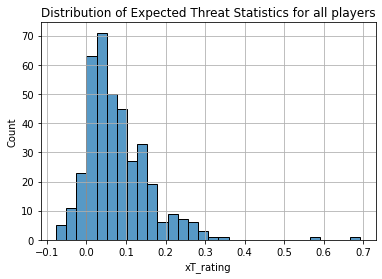

In [83]:
fig, ax = plt.subplots()
sns.histplot(players_stats_mvalues_df["xT_rating"], ax=ax)
plt.grid()
plt.title("Distribution of Expected Threat Statistics for all players")

In [85]:
players_stats_mvalues_df[players_stats_mvalues_df["xT_rating"]>0.1][["player_name", "position_code", "xT_value"]].sort_values("xT_value", ascending=False).head(10)

,player_name,position_code,xT_value
0,jordi alba ramos,LB,1.761272
1,vladimír coufal,RB,1.466600
2,aymeric laporte,CB,1.235106
3,raheem sterling,LW,1.119845
4,luke shaw,LB,1.115606
5,joshua kimmich,DM,1.068950
6,gareth frank bale,RW,1.039155
7,lorenzo insigne,LW,0.978972
8,daley blind,CB,0.947641
9,daniel olmo carvajal,AM,0.932470


By exploring xT values it's evident that players that are constructing attacks (mostly wing backs and attacking wingers)
have the highest xT values

### xG

Text(0.5, 1.0, 'Distribution of Expected Goals Statistics for all players')

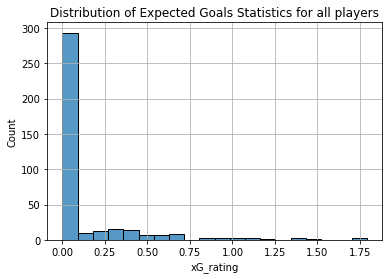

In [86]:
fig, ax = plt.subplots()
sns.histplot(players_stats_mvalues_df["xG_rating"], ax=ax, bins=20)
plt.grid()
plt.title("Distribution of Expected Goals Statistics for all players")

most of the players have very low xG

In [88]:
players_stats_mvalues_df[players_stats_mvalues_df["xG_rating"]>0.1][["player_name", "position_code", "xG_rating"]].sort_values("xG_rating", ascending=False).head(10)

,player_name,position_code,xG_rating
428,olivier giroud,CF,1.790148
404,admir mehmedi,SS,1.762506
177,mislav oršić,LW,1.458954
417,mario gavranović,CF,1.420079
239,mario pašalić,AM,1.364788
222,federico bernardeschi,RW,1.243211
26,cristiano ronaldo dos santos aveiro,CF,1.129080
227,thiago alcântara do nascimento,CM,1.119540
318,kasper dolberg,CF,1.063377
229,patrik schick,CF,1.037564


for xG it's logical that we see mostly strikers have high xG values, as they are players who creates the most of the scoring oppotrunities



### Offensive value

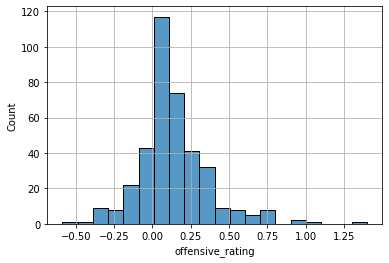

In [91]:
fig, ax = plt.subplots()
sns.histplot(players_stats_mvalues_df["offensive_rating"], ax=ax, bins=20)
plt.grid()
# plt.title("Distribution of Offensive Rating Statistics for all players")

In [96]:
players_stats_mvalues_df[players_stats_mvalues_df["offensive_rating"]>0.2][["player_name", "position_code", "offensive_rating"]].sort_values("offensive_rating", ascending=False).head(10)

,player_name,position_code,offensive_rating
239,mario pašalić,AM,1.398230
361,ante budimir,CF,1.036648
253,karol linetty,CM,0.991490
318,kasper dolberg,CF,0.922407
349,viktor claesson,LW,0.795610
147,thorgan hazard,LW,0.763665
80,xherdan shaqiri,RW,0.757877
270,robert lewandowski,CF,0.752049
146,michael gregoritsch,CF,0.751659
90,karim benzema,CF,0.750304


### Defensive value

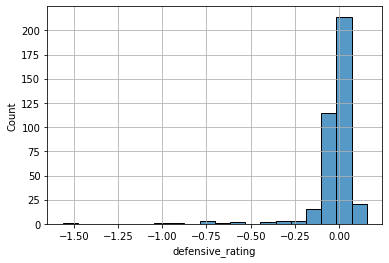

In [93]:
fig, ax = plt.subplots()
sns.histplot(players_stats_mvalues_df["defensive_rating"], ax=ax, bins=20)
plt.grid()
# plt.title("Distribution of Defensive Value Statistics for all players")

In [94]:
players_stats_mvalues_df[["player_name", "position_code", "defensive_rating"]].sort_values("defensive_rating", ascending=False).head(10)

,player_name,position_code,defensive_rating
272,vyacheslav karavaev,RB,0.157854
436,joachim andersen,CB,0.151726
158,jurriën david norman timber,CB,0.125882
240,jan bednarek,CB,0.120976
286,endre botka,RB,0.119268
223,christian nørgaard,DM,0.115453
175,ondrej celustka,CB,0.093295
346,okay yokuşlu,DM,0.091470
276,william silva de carvalho,DM,0.090967
353,pavel kadeřábek,RB,0.090221


### VAEP value

Text(0.5, 1.0, 'Distribution of Valuing Actions by Estimating Probabilities (VAEP) Statistics for all players')

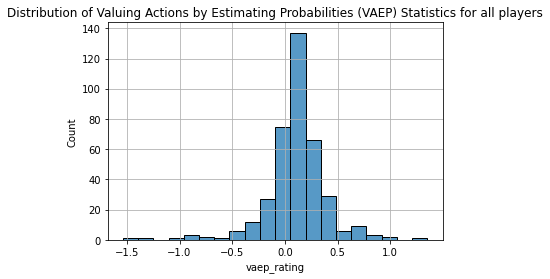

In [67]:
fig, ax = plt.subplots()
sns.histplot(players_stats_mvalues_df["vaep_rating"], ax=ax, bins=20)
plt.grid()
plt.title("Distribution of Valuing Actions by Estimating Probabilities (VAEP) Statistics for all players")

In [68]:
players_stats_mvalues_df[["player_name", "position_code", "vaep_rating"]].sort_values("vaep_rating", ascending=False).head(10)

,player_name,position_code,vaep_rating
253,mario pašalić,AM,1.352680
267,karol linetty,CM,0.979670
357,ante budimir,CF,0.937239
330,kasper dolberg,CF,0.901814
160,thorgan hazard,LW,0.818163
351,viktor claesson,LW,0.817819
383,matteo pessina,AM,0.730328
282,robert lewandowski,CF,0.716141
87,xherdan shaqiri,RW,0.716091
158,michael gregoritsch,CF,0.708745


### Market value

Text(0.5, 1.0, 'Distribution of Market Value for all players')

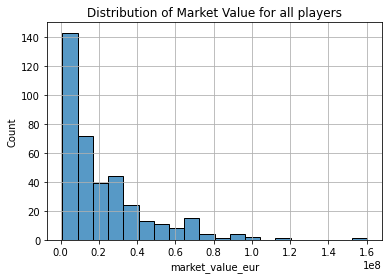

In [55]:
fig, ax = plt.subplots()
sns.histplot(players_stats_mvalues_df["market_value_eur"], ax=ax, bins=20)
plt.grid()
plt.title("Distribution of Market Value for all players")

Players in the 2020 Euro range from 1000,000 to 160,000,000 market value in EUR.

In [56]:
#explore top 10 most expensive players
players_stats_mvalues_df[["player_name", "position_code", "market_value_eur"]].sort_values("market_value_eur", ascending=False).head(10)

,player_name,position_code,market_value_eur
49,kylian mbappé lottin,CF,160000000.0
137,harry kane,CF,120000000.0
312,jadon sancho,LW,100000000.0
32,kevin de bruyne,AM,100000000.0
4,raheem sterling,LW,90000000.0
6,joshua kimmich,DM,90000000.0
58,frenkie de jong,CM,90000000.0
31,bruno miguel borges fernandes,AM,90000000.0
366,marcus rashford,LW,85000000.0
24,marcos llorente moreno,CM,80000000.0


In [57]:
#explore bottom 10 least expensive players
players_stats_mvalues_df[["player_name", "position_code", "market_value_eur"]].sort_values("market_value_eur", ascending=False).tail(10)

,player_name,position_code,market_value_eur
143,giorgio chiellini,CB,1500000.0
305,visar musliu,CB,1400000.0
290,lukáš haraslín,LW,1300000.0
181,stole dimitrievski,GK,1200000.0
337,róbert mak,LW,1200000.0
386,nemanja nikolić,CF,1200000.0
292,marcus berg,CF,1200000.0
299,endre botka,RB,1000000.0
175,darko churlinov,LW,1000000.0
356,jakub hromada,DM,1000000.0


### Age value

In [58]:
# players_stats_mvalues_df

Text(0.5, 1.0, 'Distribution of Age for all players')

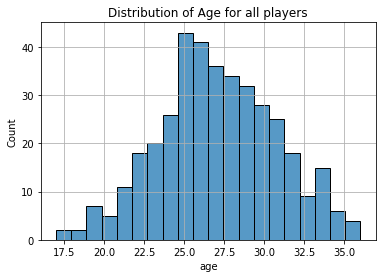

In [36]:
fig, ax = plt.subplots()
sns.histplot(players_stats_mvalues_df["age"], ax=ax, bins=20)
plt.grid()
plt.title("Distribution of Age for all players")

## 6.2 Correlation analysis of players stats and features

If we have a linear relationships between stats and Market Value it means that we can directly estimate the price of the player based on his statistics. 

<AxesSubplot:>

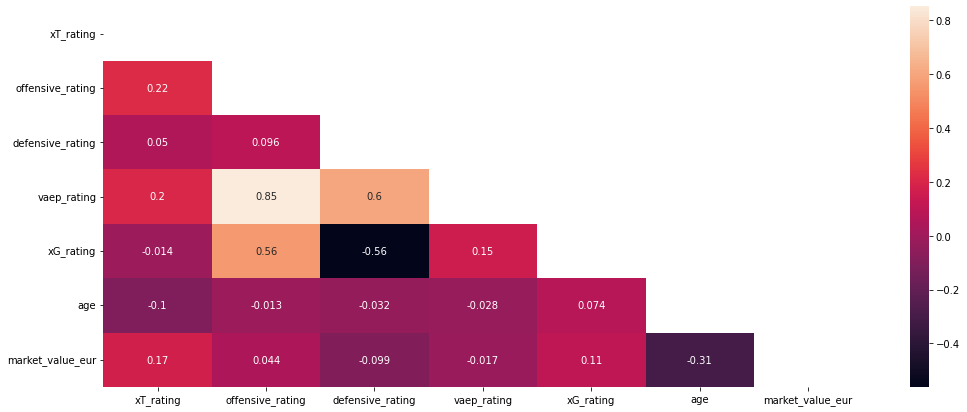

In [100]:
corr_matrix = players_stats_mvalues_df[
    [
        "xT_rating",
        "offensive_rating",
        "defensive_rating",
        "vaep_rating",
        "xG_rating",
        "age",
        "market_value_eur"
    ]
].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig = plt.figure(figsize=(17, 7))
sns.heatmap(
    corr_matrix, 
    annot=True,
        mask=mask
)


we can see that market_value_eur have the highest Correlation Coefficient (CC) with xG_value and xT_value - 0.29 and 0.26 respectivelly. Even though these values are small and we can't say there is actual dependency between these variables, but we can make an assumption that attacking players (with higher xG and xT) tend to cost more on transfer market, which is true. But this not always the case, because not only attacking players can have higth cost, but extremely defending players as well. That's why CC between stats and market value doesn't always play linearly.

Text(0.5, 1.0, 'Regression plot of market_value_eur vs xG_rating')

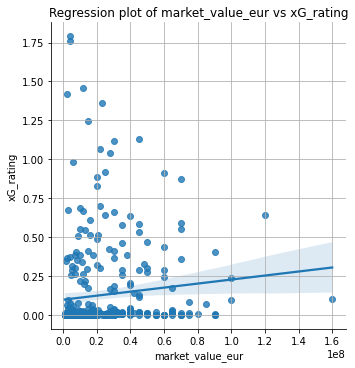

In [98]:
sns.lmplot(data=players_stats_mvalues_df, x="market_value_eur", y="xG_rating")
plt.grid()
plt.title("Regression plot of market_value_eur vs xG_rating")

Text(0.5, 1.0, 'Regression plot of market_value_eur vs xT_rating')

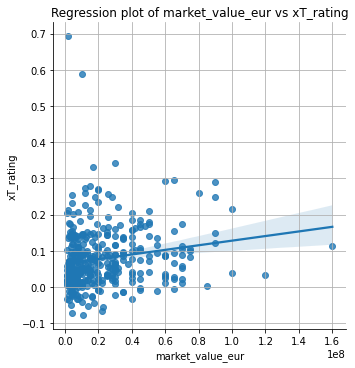

In [99]:
sns.lmplot(data=players_stats_mvalues_df, x="market_value_eur", y="xT_rating")
plt.grid()
plt.title("Regression plot of market_value_eur vs xT_rating")

# 7. Estimating Undervalued and Overvalued players based on player's Statistics and Market Value

As these stats has different margins (min and max), we need to scale each of the variable separatelly. We use MinMax Scaling for this, as a result we will get each variable having min value of 0 and max value of 1.  

Players on each position contribute differently based on stats they have, for instance for Strikers it's not that important to have good defensive numbers, while for full-backs it's important to have good defensive stats and it's not very important if they have not so good offensive numbers. For wing-backs it's important to have somewhat good both defensive and offensive stats, because they contribute a lot both for attacking and defending.  
  
we will weight each of stats compoents (xT_value, xG_value, offensive_value, defensive_value, vaep_value) by a certain fraction important for the partiuclar position. For example: for a Striker xT, xG, and offensive values are extremely important, as it serves as an indicator how well they do the job of scoring goals. So we use a weight of 1, meaning taking xG and xT values as it is. On contrary, defensive value is not that important, as they don't play in defence, even though it's good if a striker have good defensive stats. So we place a weight for defensive value as 0.2. Similar, we set a weight for VAEP as 0.5, as striker must first of all finish the attack. The full list of weights for each of the positions can be seen below

In order to calculate the cumulative statistics, we just take all the stats calculated, multiply them for a weight for a certain player position, and sum them up.  

In [102]:
#first prepare the data with normalized stats score. This needs to be done in order to calulate the combined players stats performace based on thir position
def create_normalized_data(players_stats_mvalues_df):
    scaler = MinMaxScaler()
    players_stats_mvalues_scaled_df = players_stats_mvalues_df.copy()

    players_stats_mvalues_scaled_df[
        [
            "xT_value",
            "xG_value",
            "offensive_value",
            "defensive_value",
            "vaep_value",
            "offensive_rating",
            "defensive_rating",
            "vaep_rating"
        ]
    ] = scaler.fit_transform(
        players_stats_mvalues_df[
            [
                "xT_value",
                "xG_value",
                "offensive_value",
                "defensive_value",
                "vaep_value",
                "offensive_rating",
                "defensive_rating",
                "vaep_rating"
            ]
        ]
    )
    return players_stats_mvalues_scaled_df

def compute_cumulative_stats_score(players_stats_scaled, position_code, position_weights):
    data_df = players_stats_scaled.copy()
    
    data_df["st_value"] = players_stats_scaled["xT_rating"]*position_weights[position_code]["xt_weight"] + \
        players_stats_scaled["xG_rating"]*position_weights[position_code]["xg_weight"] + \
        players_stats_scaled["offensive_rating"]*position_weights[position_code]["offensive_weight"] + \
        players_stats_scaled["vaep_rating"]*position_weights[position_code]["vaep_weight"] + \
        players_stats_scaled["defensive_rating"]*position_weights[position_code]["defensive_weight"]
    
    return data_df

def find_undervalued_players(players_stats_scaled, position_code, position_weights, performance_quant, mvalue):
    data_df = compute_cumulative_stats_score(players_stats_scaled, position_code, position_weights)
    quant_value_performace = data_df[data_df["position_code"]==position_code]["st_value"].quantile(performance_quant)
    
    underval_df = data_df[
        (data_df["position_code"]==position_code) &
        (data_df["st_value"]>quant_value_performace) &
        (data_df["market_value_eur"]<mvalue)
    ]
    return underval_df

In [103]:
#define position weight for each stat component and for each position
position_weights = {
    "CF": {
        "xt_weight": 1,
        "xg_weight": 1,
        "offensive_weight": 1,
        "vaep_weight": 0.5,
        "defensive_weight": 0.2,
    },
    "SS": {
        "xt_weight": 1,
        "xg_weight": 1,
        "offensive_weight": 1,
        "vaep_weight": 0.5,
        "defensive_weight": 0.2,
    },
    "CB": {
        "xt_weight": 0.2,
        "xg_weight": 0.1,
        "offensive_weight": 0.1,
        "vaep_weight": 1,
        "defensive_weight": 1,
    },
    "DM": {
        "xt_weight": 0.3,
        "xg_weight": 0.2,
        "offensive_weight": 0.3,
        "vaep_weight": 1,
        "defensive_weight": 0.8,
    },
    "RB": {
        "xt_weight": 0.6,
        "xg_weight": 0.3,
        "offensive_weight": 0.5,
        "vaep_weight": 1,
        "defensive_weight": 0.8,
    },
    "LB": {
        "xt_weight": 0.6,
        "xg_weight": 0.3,
        "offensive_weight": 0.5,
        "vaep_weight": 1,
        "defensive_weight": 0.8,
    },
    "LW": {
        "xt_weight": 0.8,
        "xg_weight": 0.6,
        "offensive_weight": 0.7,
        "vaep_weight": 1,
        "defensive_weight": 0.3,
    },
    "RW": {
        "xt_weight": 0.8,
        "xg_weight": 0.6,
        "offensive_weight": 0.7,
        "vaep_weight": 1,
        "defensive_weight": 0.3,
    },
    "CM": {
        "xt_weight": 0.7,
        "xg_weight": 0.7,
        "offensive_weight": 0.7,
        "vaep_weight": 1,
        "defensive_weight": 0.2,
    },
    "AM": {
        "xt_weight": 0.8,
        "xg_weight": 0.8,
        "offensive_weight": 0.8,
        "vaep_weight": 1,
        "defensive_weight": 0.1,
    },
    "LM": {
        "xt_weight": 0.8,
        "xg_weight": 0.6,
        "offensive_weight": 0.7,
        "vaep_weight": 1,
        "defensive_weight": 0.3,
    },
    "RM": {
        "xt_weight": 0.8,
        "xg_weight": 0.6,
        "offensive_weight": 0.7,
        "vaep_weight": 1,
        "defensive_weight": 0.3,
    },
    "GK": {
        "xt_weight": 0.1,
        "xg_weight": 0,
        "offensive_weight": 0.1,
        "vaep_weight": 1,
        "defensive_weight": 1,
    }
}

In [104]:
players_stats_mvalues_scaled_df = create_normalized_data(players_stats_mvalues_df)

In [105]:
#Now let's find all undervalued players for all positions. Setting the market value no more than 3000,000 EUR, 
#and have the player be within the top 25% performers of their position


underval_df_cumulative = pd.DataFrame()
for position_code in players_stats_mvalues_scaled_df["position_code"].unique():
    underval_df = find_undervalued_players(players_stats_mvalues_scaled_df, position_code, position_weights, 0.65, 3000000)
    underval_df_cumulative = pd.concat([underval_df_cumulative, underval_df]).reset_index(drop=True)



,player_id,xT_value,player_name,team_id,minutes_played,xG_value,offensive_value,defensive_value,vaep_value,vaep_rating,offensive_rating,defensive_rating,xG_rating,xT_rating,market_value_eur,dob,position_code,age,st_value
0,31042.0,0.281011,cengiz umut meraş,909.0,166.0,0.000316,0.443919,0.817558,0.476924,0.601171,0.384826,0.921829,0.000839,0.175732,2200000.0,1995-12-20,LB,25,1.636738
1,5672.0,0.206681,maciej rybus,789.0,74.0,0.011059,0.431373,0.774510,0.448655,0.616312,0.453264,0.868348,0.065807,0.213512,2000000.0,1989-08-19,LB,31,1.685472
2,30397.0,0.215792,ľubomír šatka,908.0,289.0,0.000000,0.469627,0.851437,0.513812,0.595404,0.369130,0.930245,0.000000,0.060342,2500000.0,1995-12-02,CB,25,1.574631
3,46906.0,0.143670,visar musliu,2358.0,277.0,0.000442,0.463492,0.895918,0.525362,0.605907,0.366772,0.950584,0.000703,0.016117,1400000.0,1994-11-13,CB,26,1.596462
4,20002.0,0.122965,jakub hromada,908.0,125.0,0.000000,0.408905,0.846954,0.455932,0.592683,0.343999,0.954647,0.000000,0.005918,1000000.0,1996-05-25,DM,25,1.461376
5,7979.0,0.507658,przemysław frankowski,789.0,101.0,0.000000,0.460938,0.784215,0.479749,0.650962,0.484358,0.890643,0.000000,0.692518,2000000.0,1991-01-07,CM,30,1.652904
6,42822.0,0.145628,andrás schäfer,916.0,240.0,0.190018,0.599998,0.781761,0.607375,0.680834,0.520015,0.899661,0.348636,0.020070,1500000.0,1999-04-13,CM,22,1.482871
7,5834.0,0.108149,mario gavranović,773.0,179.0,0.577266,0.591557,0.171450,0.363254,0.478106,0.584673,0.485000,1.420079,-0.010757,2500000.0,1989-11-24,CF,31,2.330049
8,9645.0,0.229018,david marshall,942.0,283.0,0.000000,0.171849,0.890084,0.253449,0.425749,0.107473,0.947200,0.000000,0.070029,2500000.0,1985-03-05,GK,36,1.390699


In [106]:
underval_df_cumulative.drop(['player_id', 'team_id', 'offensive_value', 'defensive_value', 'vaep_value', 'xG_value', 'xT_value'], axis=1)

,player_name,minutes_played,vaep_rating,offensive_rating,defensive_rating,xG_rating,xT_rating,market_value_eur,dob,position_code,age,st_value
0,cengiz umut meraş,166.0,0.601171,0.384826,0.921829,0.000839,0.175732,2200000.0,1995-12-20,LB,25,1.636738
1,maciej rybus,74.0,0.616312,0.453264,0.868348,0.065807,0.213512,2000000.0,1989-08-19,LB,31,1.685472
2,ľubomír šatka,289.0,0.595404,0.369130,0.930245,0.000000,0.060342,2500000.0,1995-12-02,CB,25,1.574631
3,visar musliu,277.0,0.605907,0.366772,0.950584,0.000703,0.016117,1400000.0,1994-11-13,CB,26,1.596462
4,jakub hromada,125.0,0.592683,0.343999,0.954647,0.000000,0.005918,1000000.0,1996-05-25,DM,25,1.461376
5,przemysław frankowski,101.0,0.650962,0.484358,0.890643,0.000000,0.692518,2000000.0,1991-01-07,CM,30,1.652904
6,andrás schäfer,240.0,0.680834,0.520015,0.899661,0.348636,0.020070,1500000.0,1999-04-13,CM,22,1.482871
7,mario gavranović,179.0,0.478106,0.584673,0.485000,1.420079,-0.010757,2500000.0,1989-11-24,CF,31,2.330049
8,david marshall,283.0,0.425749,0.107473,0.947200,0.000000,0.070029,2500000.0,1985-03-05,GK,36,1.390699
